# Demo of Yolo-V2 Tensorflow-2 implementation
This notebook intends to give a demo on the use of the implementation of Yolo in this package using the Pascal-VOC dataset. It contains all logic for training the model and for running some qualitative inspections on the predictions produced.

This notebook cannot be used to train the model from scratch. As described in the Yolo papers one needs a backbone that is first trained on e.g. an image classification task. This notebook only intends to provide training logic for training the object detector on a backbone that has already learned proper reprsentations. As a starting point a set of pretrained weights for the model as defined in this notebook can be downloaded __here__.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import tensorflow_datasets as tfds

from yolo import utils
from yolo.model import Yolo
from yolo.loss import warmup_loss, loss

In [5]:
ANCHORS = [
    [2., 2.],
    [2., 3.],
    [3., 2.],
    [6., 6.],
    [3., 8.],
    [8., 3.]
]

MAX_TRAIN_BOXES = 10

# Load the training data
We parse the PASCAL VOC definitions of the images to a format we can handle. Next, we define a `tf.data` pipeline to feed these examples to our network. We've tried to only use Tensorflow methods or Python code that can be parsed by `autograph` to have the best performance of this (simple) pipeline.

In [6]:
MAX_TRAIN_BOXES = 10

INPUT_W = 416
INPUT_H = 416

YOLO_SCALE_FACTOR = 13

N_CLASSES = 1


def get_image_and_objects(record):
    return record['image'], record['objects']


def bbox_to_matrix(image, objects):
    bbox = objects['bbox']
    
    n_boxes_to_pad = tf.maximum(
        MAX_TRAIN_BOXES - tf.shape(bbox)[0],
        0
    )

    bbox_matrix = tf.pad(bbox, [[0, n_boxes_to_pad], [0, 0]])
    bbox_matrix = bbox_matrix[:MAX_TRAIN_BOXES] # Drop any extra train boxes
    
    return image, bbox_matrix


def resize_image(image, bbox_matrix):
    resized_image = tf.image.resize(image, (INPUT_H, INPUT_W))
    
    return resized_image, bbox_matrix


def scale_boxes_to_yolo_grid(image, bbox_matrix):
    return image, bbox_matrix * YOLO_SCALE_FACTOR


def boxes_to_yx_hw_pairs(image, bbox_matrix):
    yx = bbox_matrix[:, 0:2]
    hw = bbox_matrix[:, 2:4] - bbox_matrix[:, 0:2]
    
    return image, tf.concat([yx + 0.5 * hw, hw], axis=-1)


def normalize_image_zero_one(image, bbox_matrix):
    return image / 255, bbox_matrix

In [7]:
train, test = tfds.load(
    'voc/2007',
    split=['train', 'test'],
    shuffle_files=True
)

train = (train.map(get_image_and_objects)
              .map(bbox_to_matrix)
              .map(resize_image)
              .map(scale_boxes_to_yolo_grid)
              .map(boxes_to_yx_hw_pairs)
              .map(normalize_image_zero_one)
              .shuffle(1500)
              .batch(5))

test = (test.map(get_image_and_objects)
            .map(bbox_to_matrix)
            .map(resize_image)
            .map(scale_boxes_to_yolo_grid)
            .map(boxes_to_yx_hw_pairs)
            .map(normalize_image_zero_one))

# Define the model and load pretrained weights.

In [8]:
yolo = Yolo(n_labels=N_CLASSES, anchors=ANCHORS)

yolo.model.load_weights('reasonable_model_voc.h5')

# Warmup loss

In [ ]:
EPOCHS = 1
ROUNDS = 50

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)


for epoch in range(EPOCHS):
    print("New Epoch")
    
    epoch_losses = []
    for i, (X, y_true) in enumerate(train):
        with tf.GradientTape() as tape:
            y_pred = yolo.model(X, training=True)
            loss_tensor = warmup_loss(y_pred, yolo)
            
            epoch_losses.append(loss_tensor)
            
            if i % 5 == 0:
                print("Curr loss %.3f" % (sum(epoch_losses)/len(epoch_losses)))
                
            if i > ROUNDS:
                break
            
        grads = tape.gradient(loss_tensor, yolo.model.trainable_variables)
        optimizer.apply_gradients(zip(grads, yolo.model.trainable_variables))

In [ ]:
EPOCHS = 30

optimizer = tf.keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.000001)
for epoch in range(EPOCHS):
    print("New Epoch")

    epoch_losses = []
    for i, (X, y_true) in enumerate(train):
        with tf.GradientTape() as tape:
            y_pred = yolo.model(X, training=True)
            loss_tensor = loss(y_pred, y_true, yolo)

            epoch_losses.append(loss_tensor)

            if i % 10 == 0:
                print("Curr loss %.3f" % (sum(epoch_losses)/len(epoch_losses)))

            grads = tape.gradient(loss_tensor, yolo.model.trainable_variables)

            optimizer.apply_gradients(zip(grads, yolo.model.trainable_variables))

# Qualitative inspection of predictions
Just to get a feel whether the model is learning anything at all (and hence if this implementation is (mostly) wired correctly) we'll make a few predictions on images from the test set and see how the bounding boxes match up with the true ones.

In [17]:
def plot_image_with_boxes_on_axes(image, pred_boxes, true_boxes, ax):
    ax.imshow(image)
    
    # Normalize boxes in 0-1 format to boxes that match the image shape
    pred_boxes = pred_boxes * [*image.shape[:2], *image.shape[:2]]
    true_boxes = true_boxes * [*image.shape[:2], *image.shape[:2]]
    
    for box in pred_boxes:
        rect = patches.Rectangle(
            (box[1], box[0]),
            box[3] - box[1],
            box[2] - box[0],
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )

        ax.add_patch(rect)
        
    for box in true_boxes:
        rect = patches.Rectangle(
            (box[1], box[0]),
            box[3] - box[1],
            box[2] - box[0],
            linewidth=1,
            edgecolor='b',
            facecolor='none'
        )

        ax.add_patch(rect)

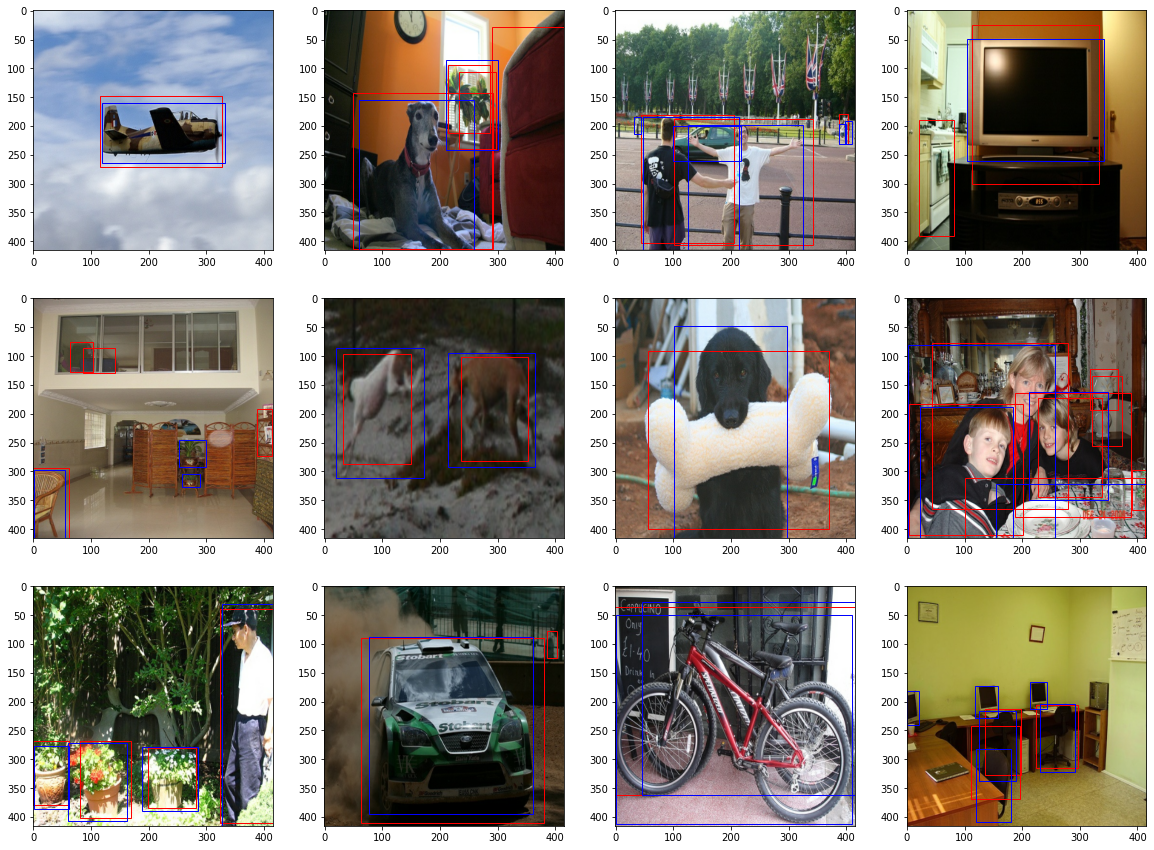

In [23]:
N_IMAGES = 12
N_COLS = 4
N_ROWS = math.ceil(N_IMAGES / N_COLS)

SCORE_THRESHOLD = 0.7


fig, axs = plt.subplots(ncols=N_COLS, nrows=N_ROWS, figsize=(5*N_COLS, 5*N_ROWS))

for ax, (image, true_boxes) in zip(axs.reshape(-1), test.take(N_IMAGES)):
    y_pred = yolo.model(image[None, ...], training=False)
    
    # Convert all boxes to coordinates and drop the batch dimension 
    # since we are predicting on a single image
    y_pred, _ = utils.get_base_and_predicted_boxes(y_pred, yolo)
    y_pred_coords = utils.boxes_to_coords(y_pred)[0]
    y_pred_conf = y_pred[..., 4][0]
    
    nms_ind = tf.image.non_max_suppression(
        y_pred_coords,
        y_pred_conf,
        max_output_size=10,
        score_threshold=SCORE_THRESHOLD
    )
    
    boxes = tf.gather(y_pred_coords, nms_ind)
    boxes = boxes / 13  # Horrible hack, but Yolo works on a 13 x 13 grid. This converts boxes to 0-1
    true_boxes = utils.boxes_to_coords(true_boxes) / 13
    
    plot_image_with_boxes_on_axes(image, boxes, true_boxes, ax)